In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import medmnist
from medmnist import INFO, Evaluator

In [2]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


In [3]:
data_flag = 'chestmnist'
# data_flag = 'breastmnist'
download = False

NUM_EPOCHS = 10
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [4]:
from torch.utils.data import DataLoader


# Preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Load datasets (already split)
train_dataset = DataClass(split='train', transform=data_transform, download=download)
validation_dataset = DataClass(split='val', transform=data_transform, download=download)  # Use 'val' instead of splitting
test_dataset = DataClass(split='test', transform=data_transform, download=download)

# Encapsulate datasets into DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

# Print dataset sizes
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(validation_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 78468
Validation samples: 11219
Test samples: 22433


In [5]:
print(train_dataset)
print("===================")
print(validation_dataset)
print("===================")
print(test_dataset)

Dataset ChestMNIST of size 28 (chestmnist)
    Number of datapoints: 78468
    Root location: /home/oussama/.medmnist
    Split: train
    Task: multi-label, binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'atelectasis', '1': 'cardiomegaly', '2': 'effusion', '3': 'infiltration', '4': 'mass', '5': 'nodule', '6': 'pneumonia', '7': 'pneumothorax', '8': 'consolidation', '9': 'edema', '10': 'emphysema', '11': 'fibrosis', '12': 'pleural', '13': 'hernia'}
    Number of samples: {'train': 78468, 'val': 11219, 'test': 22433}
    Description: The ChestMNIST is based on the NIH-ChestXray14 dataset, a dataset comprising 112,120 frontal-view X-Ray images of 30,805 unique patients with the text-mined 14 disease labels, which could be formulized as a multi-label binary-class classification task. We use the official data split, and resize the source images of 1×1024×1024 into 1×28×28.
    License: CC BY 4.0
Dataset ChestMNIST of size 28 (chestmnist)
    Number of datapoints: 11219


In [6]:
# visualization

train_dataset.montage(length=1)

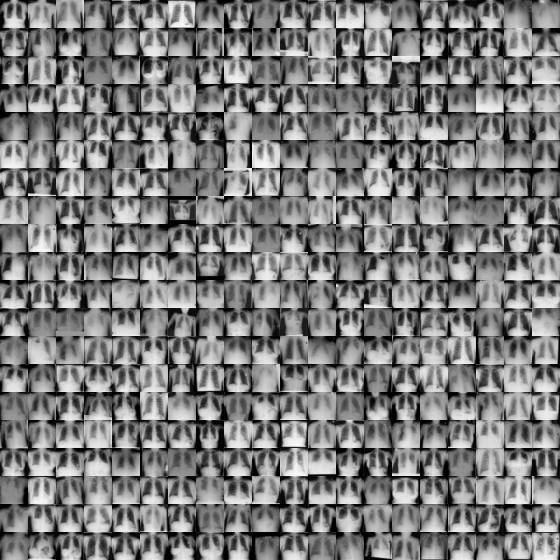

In [7]:
# montage

train_dataset.montage(length=20)

In [10]:
from PIL import Image
import numpy as np

# Get a single image from the test dataset
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Take the first image from the batch
img = images[0]

# Denormalize the image (reverse the normalization we applied)
# The formula is: image = image * std + mean
img_denormalized = img * 0.5 + 0.5  # Using the same mean=0.5, std=0.5 from your transforms

# Convert to numpy and transpose dimensions if needed
# PyTorch tensors are (C, H, W) but we need (H, W, C) for saving
if img_denormalized.shape[0] == 1:  # Grayscale image
    img_np = img_denormalized.squeeze().numpy()  # Remove channel dimension for grayscale
else:  # Color image
    img_np = img_denormalized.permute(1, 2, 0).numpy()  # Change from (C,H,W) to (H,W,C)

# Convert to uint8 for saving as image
img_np = (img_np * 255).astype(np.uint8)

# Save as PNG
if img_denormalized.shape[0] == 1:  # For grayscale images
    Image.fromarray(img_np, mode='L').save('images/chestxray/test_image.png')
else:  # For RGB images
    Image.fromarray(img_np).save('test_image.png')

print(f"Image saved as test_image.png")

Image saved as test_image.png


In [19]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [20]:
class Square(torch.nn.Module):
    def forward(self, x):
        return x**2

class Flatten(torch.nn.Module):
    def forward(self, x):
        return torch.flatten(x, 1)

In [21]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        # Main path
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)  # Normalize activations
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Skip connection with downsampling if needed
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                          stride=stride, bias=False),  # Kernel=1 to preserve spatial dimensions
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        identity = x

        # Main path
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # Adjust identity shape if needed
        if self.downsample is not None:
            identity = self.downsample(x)
        
        # Add skip connection
        out += identity
        out = self.relu(out)
        
        return out
    
class Lenet5(nn.Module):
    def __init__(self, outputs=2):
        super(Lenet5, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)  # Reduce feature map size

        self.res1 = ResidualBlock(in_channels=6, out_channels=16, stride=1)
        # Second pooling layer to further reduce size
        self.pool2 = nn.AvgPool2d(kernel_size = 2, stride = 2)  # ADDED: Extra pooling layer

        self.Flatten = Flatten()

        # Fully connected layer
        self.fc1 = nn.Linear(in_features=576, out_features=120)  # Reduced size
        self.fc2 = nn.Linear(in_features=120, out_features=84)  # Reduced size
        self.fc3 = nn.Linear(in_features=84, out_features=outputs)  # Reduced size

    def forward(self, input):
        output = self.conv1(input)
        output = self.relu1(output)
        output = self.pool(output)
    
        output = self.res1(output)
        output = self.pool2(output)  # Apply extra pooling layer

        output = self.Flatten(output)

        output = self.fc1(output)
        output = self.fc2(output)
        output = self.fc3(output)
        return output
    
model = Lenet5(outputs=n_classes)
model = model.to(device)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

## Next, we can start to train and evaluate!

In [22]:
# Initialize lists to store accuracy and loss
train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []

In [23]:
# train

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    validation_correct = 0
    validation_total = 0
    running_loss = 0.0
    
    model.train()
    print(f"\nEpoch [{epoch+1}/{NUM_EPOCHS}] Training...")
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs = inputs.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32).to(device)
            loss = criterion(outputs, targets)
            predicted = (outputs > 0.5).float()  # Binary classification threshold
        else:
            targets = targets.squeeze().long().to(device)
            loss = criterion(outputs, targets)
            predicted = torch.argmax(outputs, dim=1)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_correct += (predicted == targets).sum().item()
        train_total += targets.numel()


    train_accuracy = 100 * train_correct / train_total
    train_loss = running_loss / len(train_loader)

    # Store train loss and accuracy
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluation phase
    model.eval()
    validation_loss = 0.0
    with torch.no_grad():
        for inputs, targets in validation_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32).to(device)
                loss = criterion(outputs, targets)
                predicted = (outputs > 0.5).float()
            else:
                targets = targets.squeeze().long().to(device)
                loss = criterion(outputs, targets)
                predicted = torch.argmax(outputs, dim=1)

            validation_loss += loss.item()
            validation_correct += (predicted == targets).sum().item()
            validation_total += targets.numel()

        validation_accuracy = 100 * validation_correct / validation_total
        validation_loss /= len(test_loader)

    # Store test loss and accuracy
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

    print(f"\nSummary: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Validation Loss: {validation_loss:.4f}, Validation Acc: {validation_accuracy:.2f}%")



Epoch [1/10] Training...


100%|██████████| 614/614 [00:14<00:00, 43.35it/s]



Summary: Train Loss: 0.2302, Train Acc: 94.86%, Validation Loss: 0.0905, Validation Acc: 94.92%

Epoch [2/10] Training...


100%|██████████| 614/614 [00:13<00:00, 44.78it/s]



Summary: Train Loss: 0.1813, Train Acc: 94.86%, Validation Loss: 0.0890, Validation Acc: 94.92%

Epoch [3/10] Training...


100%|██████████| 614/614 [00:13<00:00, 46.49it/s]



Summary: Train Loss: 0.1794, Train Acc: 94.86%, Validation Loss: 0.0884, Validation Acc: 94.92%

Epoch [4/10] Training...


100%|██████████| 614/614 [00:12<00:00, 47.58it/s]



Summary: Train Loss: 0.1783, Train Acc: 94.86%, Validation Loss: 0.0880, Validation Acc: 94.92%

Epoch [5/10] Training...


100%|██████████| 614/614 [00:13<00:00, 46.39it/s]



Summary: Train Loss: 0.1778, Train Acc: 94.86%, Validation Loss: 0.0877, Validation Acc: 94.92%

Epoch [6/10] Training...


100%|██████████| 614/614 [00:12<00:00, 47.40it/s]



Summary: Train Loss: 0.1771, Train Acc: 94.86%, Validation Loss: 0.0875, Validation Acc: 94.92%

Epoch [7/10] Training...


100%|██████████| 614/614 [00:13<00:00, 46.97it/s]



Summary: Train Loss: 0.1768, Train Acc: 94.86%, Validation Loss: 0.0873, Validation Acc: 94.92%

Epoch [8/10] Training...


100%|██████████| 614/614 [00:13<00:00, 47.16it/s]



Summary: Train Loss: 0.1766, Train Acc: 94.86%, Validation Loss: 0.0871, Validation Acc: 94.92%

Epoch [9/10] Training...


100%|██████████| 614/614 [00:12<00:00, 48.42it/s]



Summary: Train Loss: 0.1766, Train Acc: 94.86%, Validation Loss: 0.0870, Validation Acc: 94.92%

Epoch [10/10] Training...


100%|██████████| 614/614 [00:13<00:00, 44.16it/s]



Summary: Train Loss: 0.1759, Train Acc: 94.86%, Validation Loss: 0.0868, Validation Acc: 94.92%


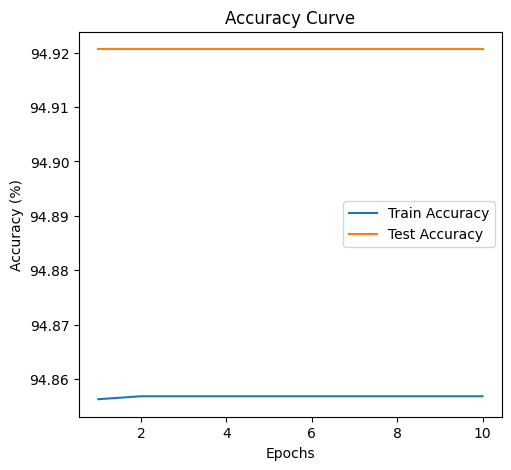

In [25]:
# Plot accuracy and loss curves
epochs = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, validation_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curve')
plt.legend()

plt.show()

In [26]:
# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0
test_loss = 0.0

print("\nTesting the model on the test dataset...")
with torch.no_grad():  # No need to compute gradients during testing
    for inputs, targets in test_loader:
        inputs = inputs.to(device)

        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32).to(device)
            loss = criterion(outputs, targets)
            predicted = (outputs > 0.5).float()  # Binary classification threshold
        else:
            targets = targets.squeeze().long().to(device)
            loss = criterion(outputs, targets)
            predicted = torch.argmax(outputs, dim=1)

        test_loss += loss.item()
        test_correct += (predicted == targets).sum().item()
        test_total += targets.numel()

# Compute final test accuracy and loss
test_accuracy = 100 * test_correct / test_total
test_loss /= len(test_loader)

print(f"\nFinal Test Results: Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%")


Testing the model on the test dataset...

Final Test Results: Loss: 0.1794, Accuracy: 94.74%


In [27]:
#input example
dummy_input = torch.randn(1, 1, 28, 28)

# Define the ONNX file path
onnx_path = "../ONNXModels/chestxray.onnx"

model.to("cpu")
# Export model to ONNX
torch.onnx.export(
    model,                        # Model to export
    dummy_input,                   # Example input
    onnx_path,                     # File path
    export_params=True,             # Store trained parameters
    # training=torch.onnx.TrainingMode.TRAINING,
    opset_version=11,               # ONNX version (11 is widely supported)
    do_constant_folding=True,       # Optimize constant folding
    input_names=["input"],          # Input tensor name
    output_names=["output"],        # Output tensor name
    dynamic_axes={                  # Support variable batch size
        "input": {0: "batch_size"},
        "output": {0: "batch_size"}
    }
)